In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import seaborn as sns
import re

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
df_master=pd.read_csv('master.csv')

In [3]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        8364 non-null   float64
 9    gdp_for_year ($)   27820 non-null  object 
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


In [4]:
df_master.rename(columns={' gdp_for_year ($) ': 'gdp_for_year','gdp_per_capita ($)':'gdp_per_capita','suicides/100k pop' : 'suicidesper100k'},inplace=True)

In [5]:
df_master['year'].unique()

array([1987, 1988, 1989, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
       2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       1985, 1986, 1990, 1991, 2012, 2013, 2014, 2015, 2011, 2016],
      dtype=int64)

In [6]:
# We will take data from 2000 to 2015..

df = df_master[(df_master['year']>=2000) & (df_master['year']<=2015)]

In [7]:
#Shape of dataframe

df.shape

(16008, 12)

In [8]:
#Listing the features of the dataset

df.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicidesper100k', 'country-year', 'HDI for year', 'gdp_for_year',
       'gdp_per_capita', 'generation'],
      dtype='object')

In [9]:
# # We only include columns that have less zeroes and null values..


# df = df[['country', 'year', 'sex', 'age', 'suicides_no', 'population',
#        'suicidesper100k','yearlyHDI', 'GDPpyear',
#        'GDPpcapital', 'generation','suicide%','Individuals using the Internet (% of population)',
#        'Expense (% of GDP)', 'Compensation of employees (% of expense)',
#        'Unemployment, total (% of total labor force) (modeled ILO estimate)',
#        'Physicians (per 1,000 people)','Labor force, total','Mobile cellular subscriptions (per 100 people)',
#        'Refugee population by country or territory of origin',
#        'Contributing family workers, total (% of total employment) (modeled ILO estimate)',
#        'Access to electricity (% of population)',]]


### Initial Preprocessing

In [10]:
df.head()

,country,year,sex,age,suicides_no,population,suicidesper100k,country-year,HDI for year,gdp_for_year,gdp_per_capita,generation
132,Albania,2000,male,25-34 years,17,232000,7.33,Albania2000,0.656,"3,632,043,908",1299,Generation X
133,Albania,2000,male,55-74 years,10,177400,5.64,Albania2000,0.656,"3,632,043,908",1299,Silent
134,Albania,2000,female,75+ years,2,37800,5.29,Albania2000,0.656,"3,632,043,908",1299,G.I. Generation
135,Albania,2000,male,75+ years,1,24900,4.02,Albania2000,0.656,"3,632,043,908",1299,G.I. Generation
136,Albania,2000,female,15-24 years,6,263900,2.27,Albania2000,0.656,"3,632,043,908",1299,Generation X


#### Exploring the distribution of the target variable

C:\Users\user\AppData\Local\Temp\ipykernel_12796\1886523550.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['suicidesper100k'], color='g', bins=100)


<Axes: xlabel='suicidesper100k', ylabel='Density'>

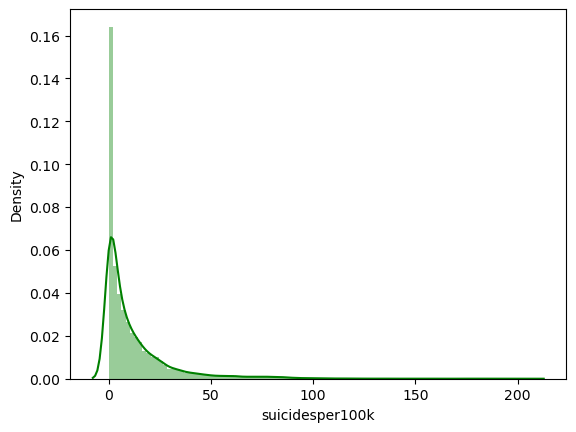

In [11]:
sns.distplot(df['suicidesper100k'], color='g', bins=100)

C:\Users\user\AppData\Local\Temp\ipykernel_12796\3786065852.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(df['suicidesper100k']+1), color='g', bins=100)


<Axes: xlabel='suicidesper100k', ylabel='Density'>

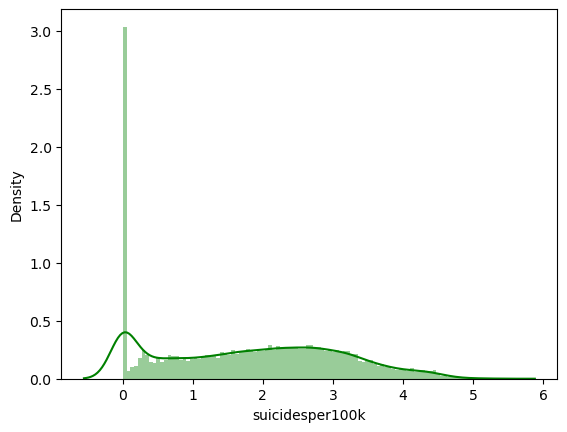

In [12]:
sns.distplot(np.log(df['suicidesper100k']+1), color='g', bins=100)

In [13]:
# Identifyig the numeric variables

numeric = df.select_dtypes(include = ['number']).columns.values.tolist()

# numeric.remove('Id')

numeric

['year',
 'suicides_no',
 'population',
 'suicidesper100k',
 'HDI for year',
 'gdp_per_capita']

In [14]:
# Creating a list of the categoricl variables

cat_vars = df.select_dtypes(include = ['object']).columns.values.tolist()

cat_vars

['country', 'sex', 'age', 'country-year', 'gdp_for_year', 'generation']

In [15]:
# We should drop the country-year and ,gdp for year to numerical,
df.drop(columns=['country-year'],inplace=True)

In [16]:
# df['year'] = df['year'].astype('str')

In [17]:
df['gdp_for_year'] = df['gdp_for_year'].str.replace(',','',regex=True).astype(float)
df['gdp_for_year'] = df['gdp_for_year'].astype('float')

In [18]:
# Re - identifying the numeric variables

# Identifyig the numeric variables

numeric = df.select_dtypes(include = ['number']).columns.values.tolist()

# numeric.remove('Id')

numeric

['year',
 'suicides_no',
 'population',
 'suicidesper100k',
 'HDI for year',
 'gdp_for_year',
 'gdp_per_capita']

In [19]:
# Re-identifying the  categoricl variables

cat_vars = df.select_dtypes(include = ['object']).columns.values.tolist()

cat_vars

['country', 'sex', 'age', 'generation']

<Figure size 2500x2000 with 0 Axes>

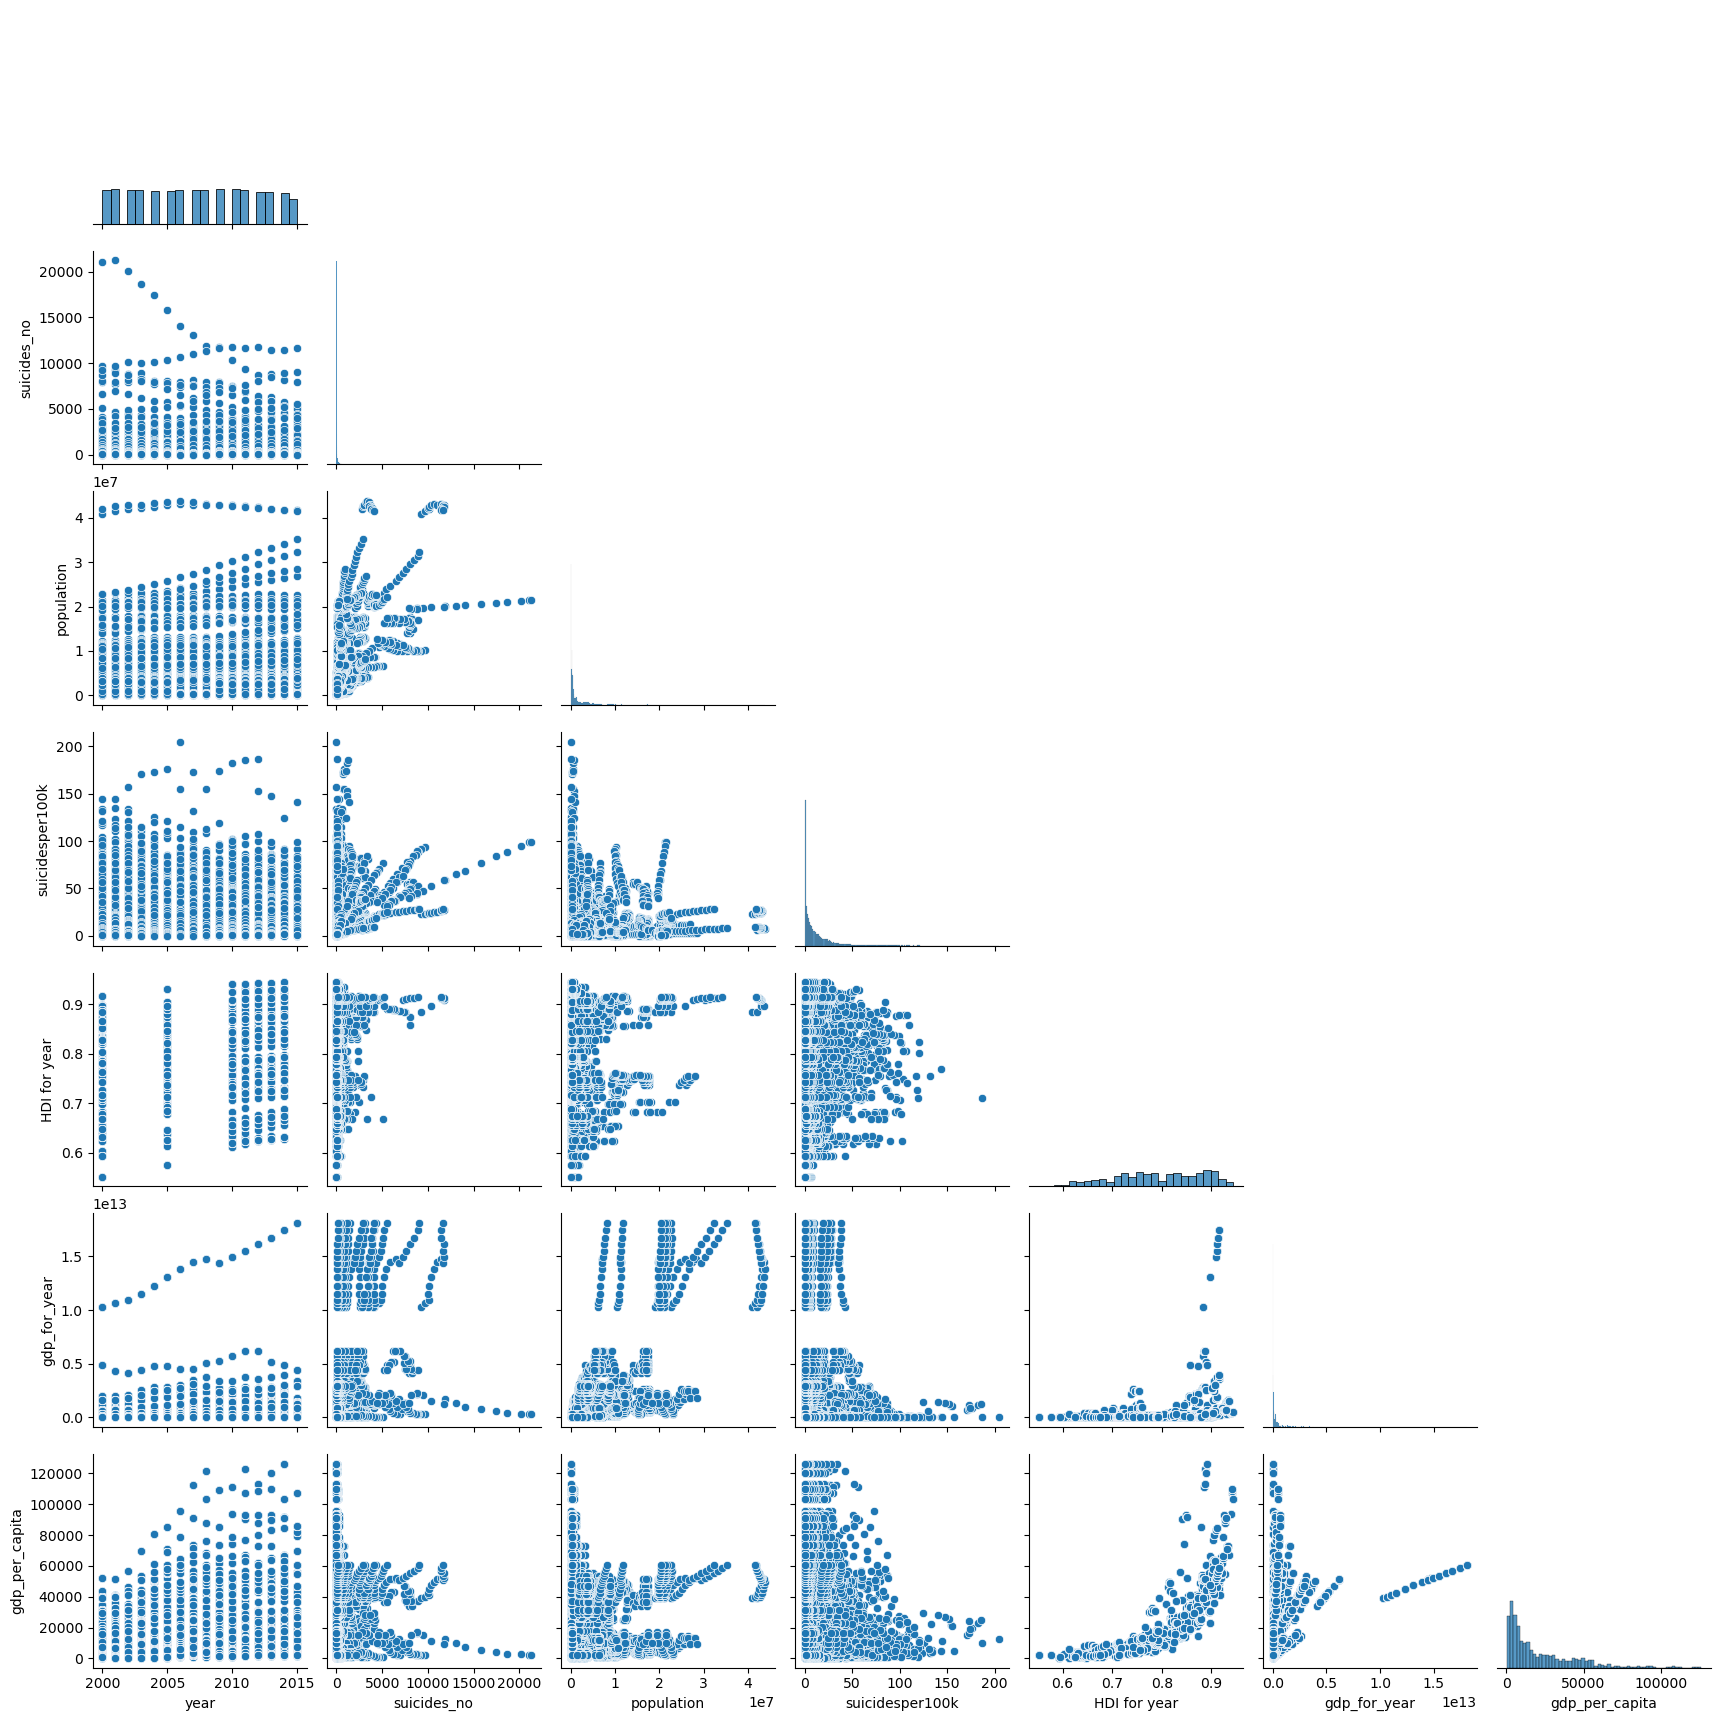

In [20]:
# Exploring pairplots between numeric variables..

plt.figure(figsize=(25,20))

sns.pairplot(df[numeric],corner=True)

# g.fig.set_figheight(25)
# g.fig.set_figwidth(20)
# plt.show()

#### Correlation plot

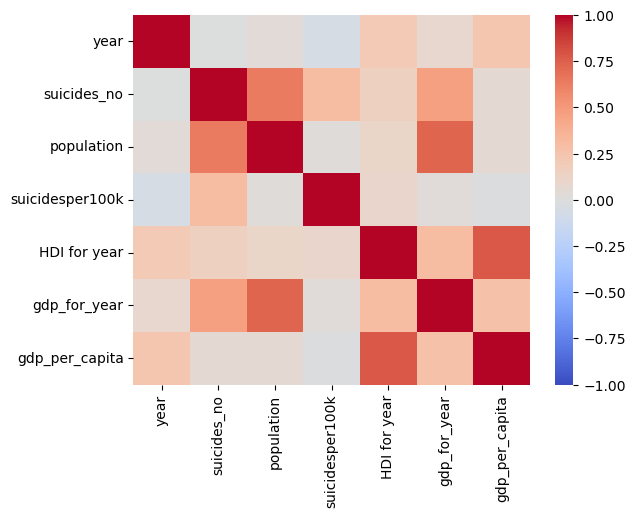

In [21]:
df_numeric = df[numeric]

sns.heatmap(
    df_numeric.corr(), 
    vmin=-1, 
    vmax=1, 
    cmap="coolwarm",
    annot=False
)
plt.savefig('Correlation Plot.png',dpi=110,bbox_inches='tight')

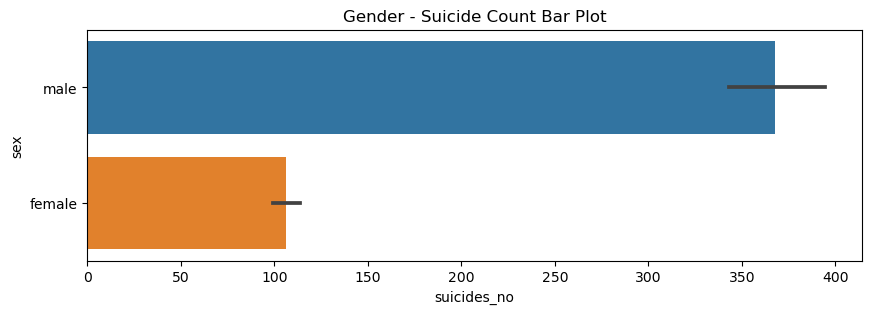

In [22]:
#Gender and suicide count bar plot

plt.figure(figsize=(10,3))
sns.barplot(x=df.suicides_no,y=df.sex)
plt.title('Gender - Suicide Count Bar Plot')
plt.show()

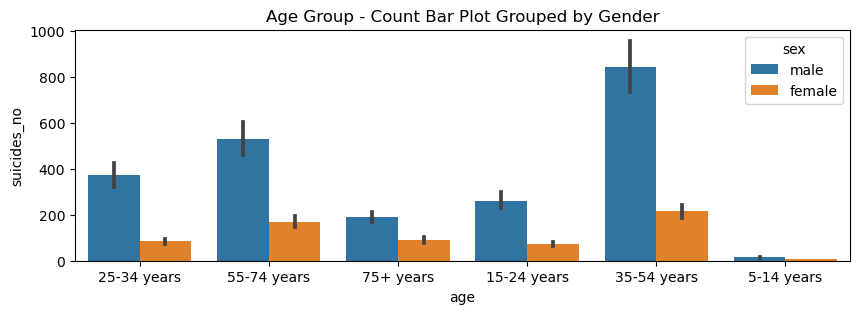

In [23]:
#Age Group - Count Bar Plot Grouped by Gender

plt.figure(figsize=(10,3))
sns.barplot(x = "age", y = "suicides_no", hue = "sex", data = df)
plt.title("Age Group - Count Bar Plot Grouped by Gender")
plt.show()

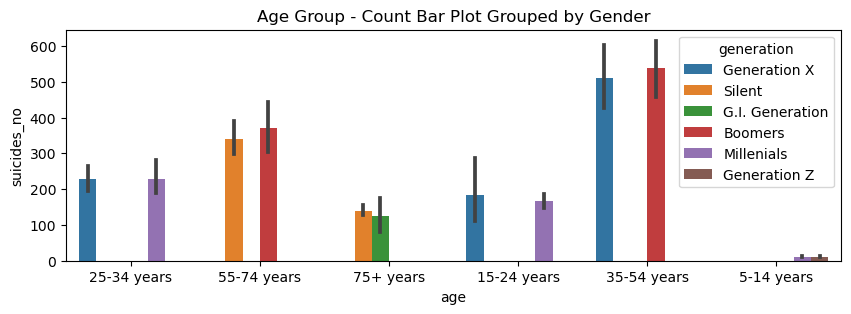

In [24]:
#Age Group - Count Bar Plot Grouped by Generation

plt.figure(figsize=(10,3))
sns.barplot(x = "age", y = "suicides_no", hue = "generation", data = df)
plt.title("Age Group - Count Bar Plot Grouped by Gender")
plt.show()

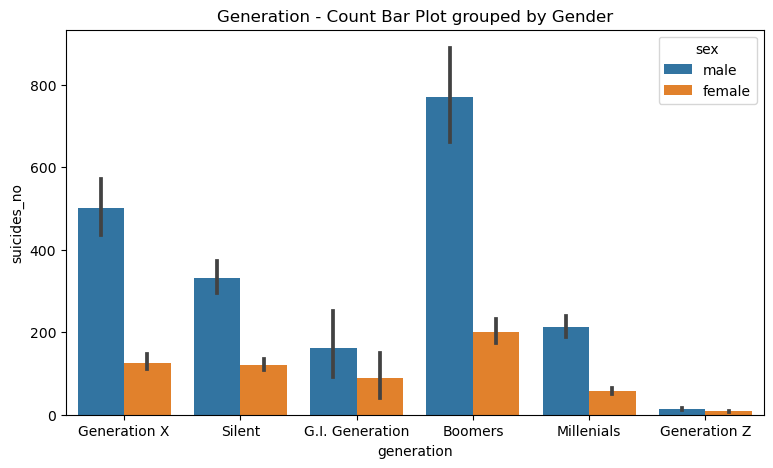

In [25]:
#Generation - Count Bar Plot grouped by Gender

plt.figure(figsize=(9,5))
sns.barplot(x = "generation", y = "suicides_no", hue = "sex", data = df)
plt.title('Generation - Count Bar Plot grouped by Gender')
plt.show()

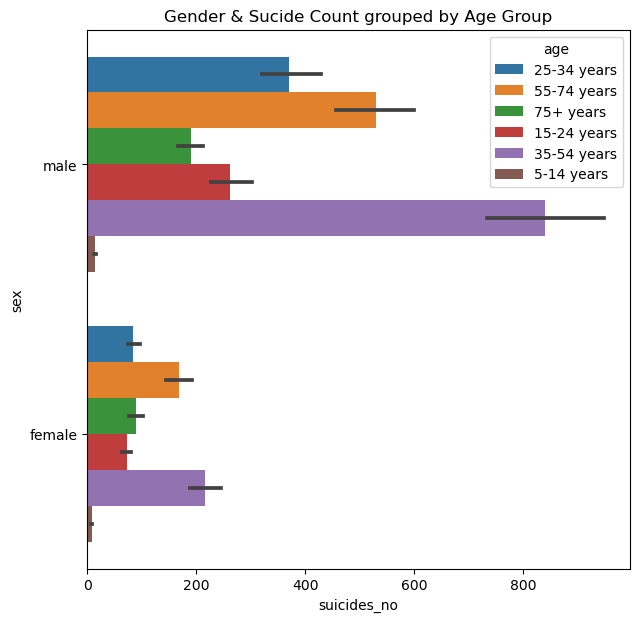

In [26]:
#Gender & Sucide Count grouped by Age Group bar plot

plt.figure(figsize=(7,7))
sns.barplot(y="sex", x="suicides_no", hue="age", data=df)
plt.title('Gender & Sucide Count grouped by Age Group')
plt.show()

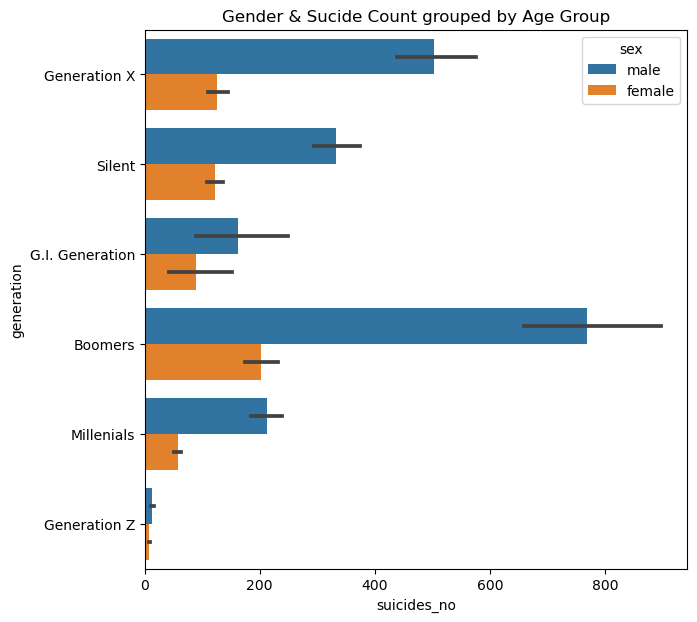

In [27]:
#Gender & Sucide Count grouped by Age Group bar plot

plt.figure(figsize=(7,7))
sns.barplot(y="generation", x="suicides_no", hue="sex", data=df)
plt.title('Gender & Sucide Count grouped by Age Group')
plt.show()

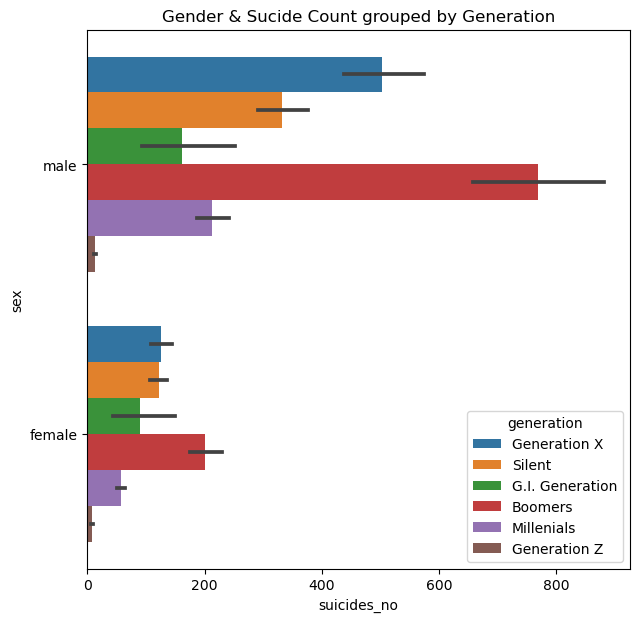

In [28]:
#Gender & Sucide Count grouped by Generation bar plot

plt.figure(figsize=(7,7))
sns.barplot(y="sex", x="suicides_no", hue="generation", data=df)
plt.title('Gender & Sucide Count grouped by Generation')
plt.show()

In [29]:
df_sorted =   df.groupby(['country']).agg(Avg_Suicide_Rate=('suicidesper100k','mean')).sort_values(['Avg_Suicide_Rate'],ascending=False)


df_sorted.reset_index(inplace=True)

df_sorted

,country,Avg_Suicide_Rate
0,Lithuania,38.015208
1,Republic of Korea,35.543646
2,Russian Federation,31.338229
3,Guyana,30.191667
4,Sri Lanka,30.104000
...,...,...
92,Antigua and Barbuda,0.874405
93,Barbados,0.834881
94,Oman,0.736111
95,Jamaica,0.688583


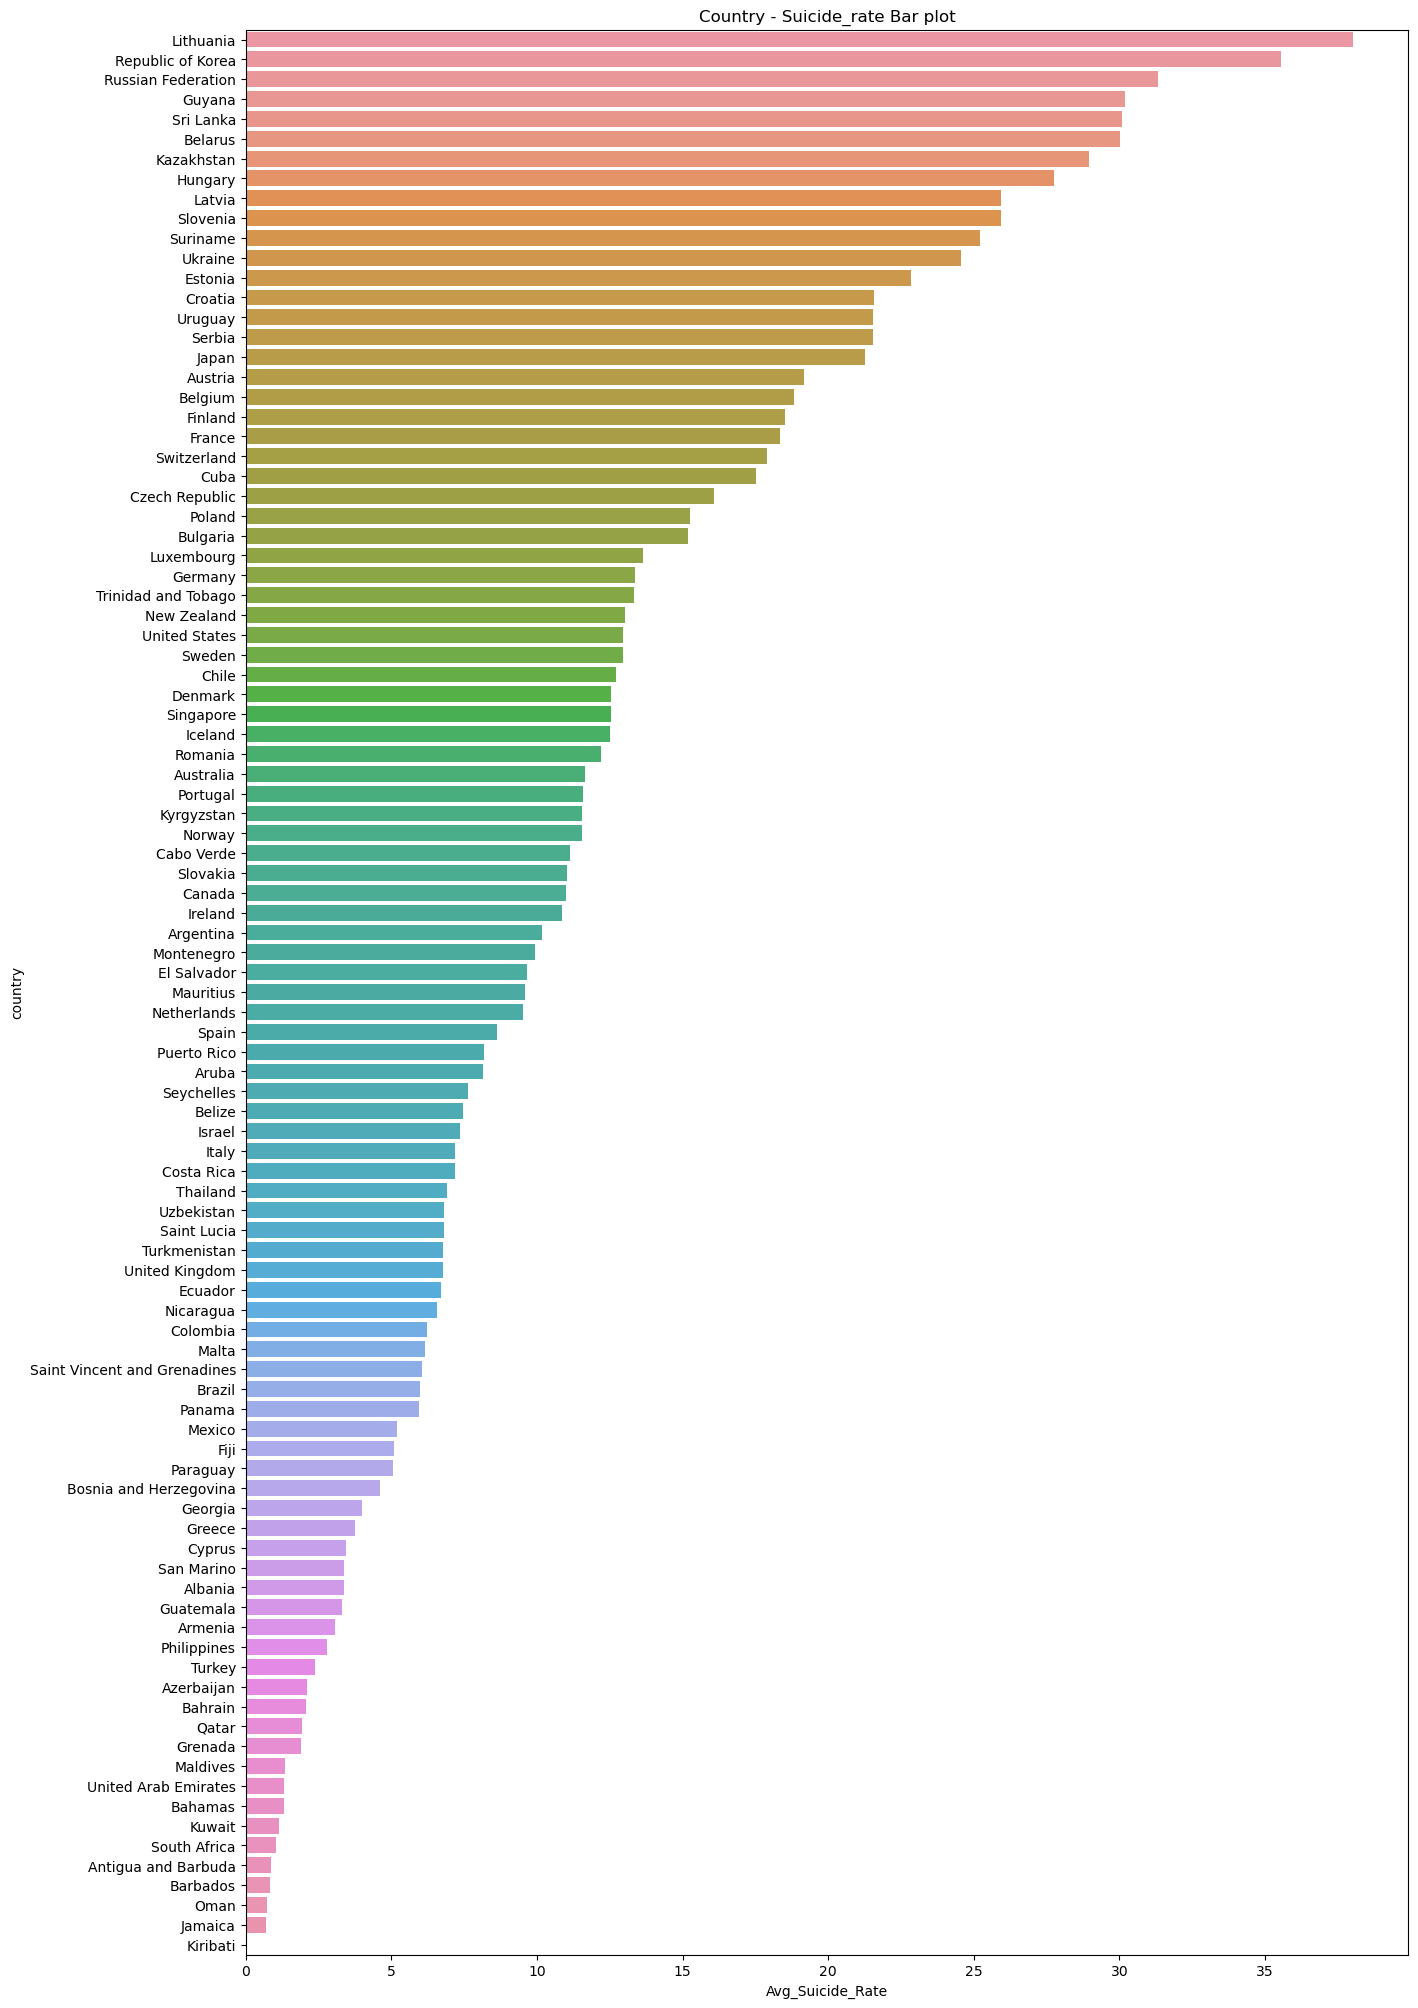

In [30]:
#Country & Suicide_rate Bar plot

plt.figure(figsize=(15,25))
sns.barplot(x = "Avg_Suicide_Rate", y = "country", data = df_sorted)
plt.title('Country - Suicide_rate Bar plot')
plt.show()

In [31]:
df_sorted  =  df.groupby(['country']).agg(Suicide_No=('suicides_no','sum')).sort_values(['Suicide_No'],ascending=False)


df_sorted.reset_index(inplace=True)

df_sorted

,country,Suicide_No
0,Russian Federation,649026
1,United States,575514
2,Japan,460105
3,Republic of Korea,194847
4,Germany,164279
...,...,...
92,Maldives,20
93,Grenada,18
94,Antigua and Barbuda,9
95,San Marino,2


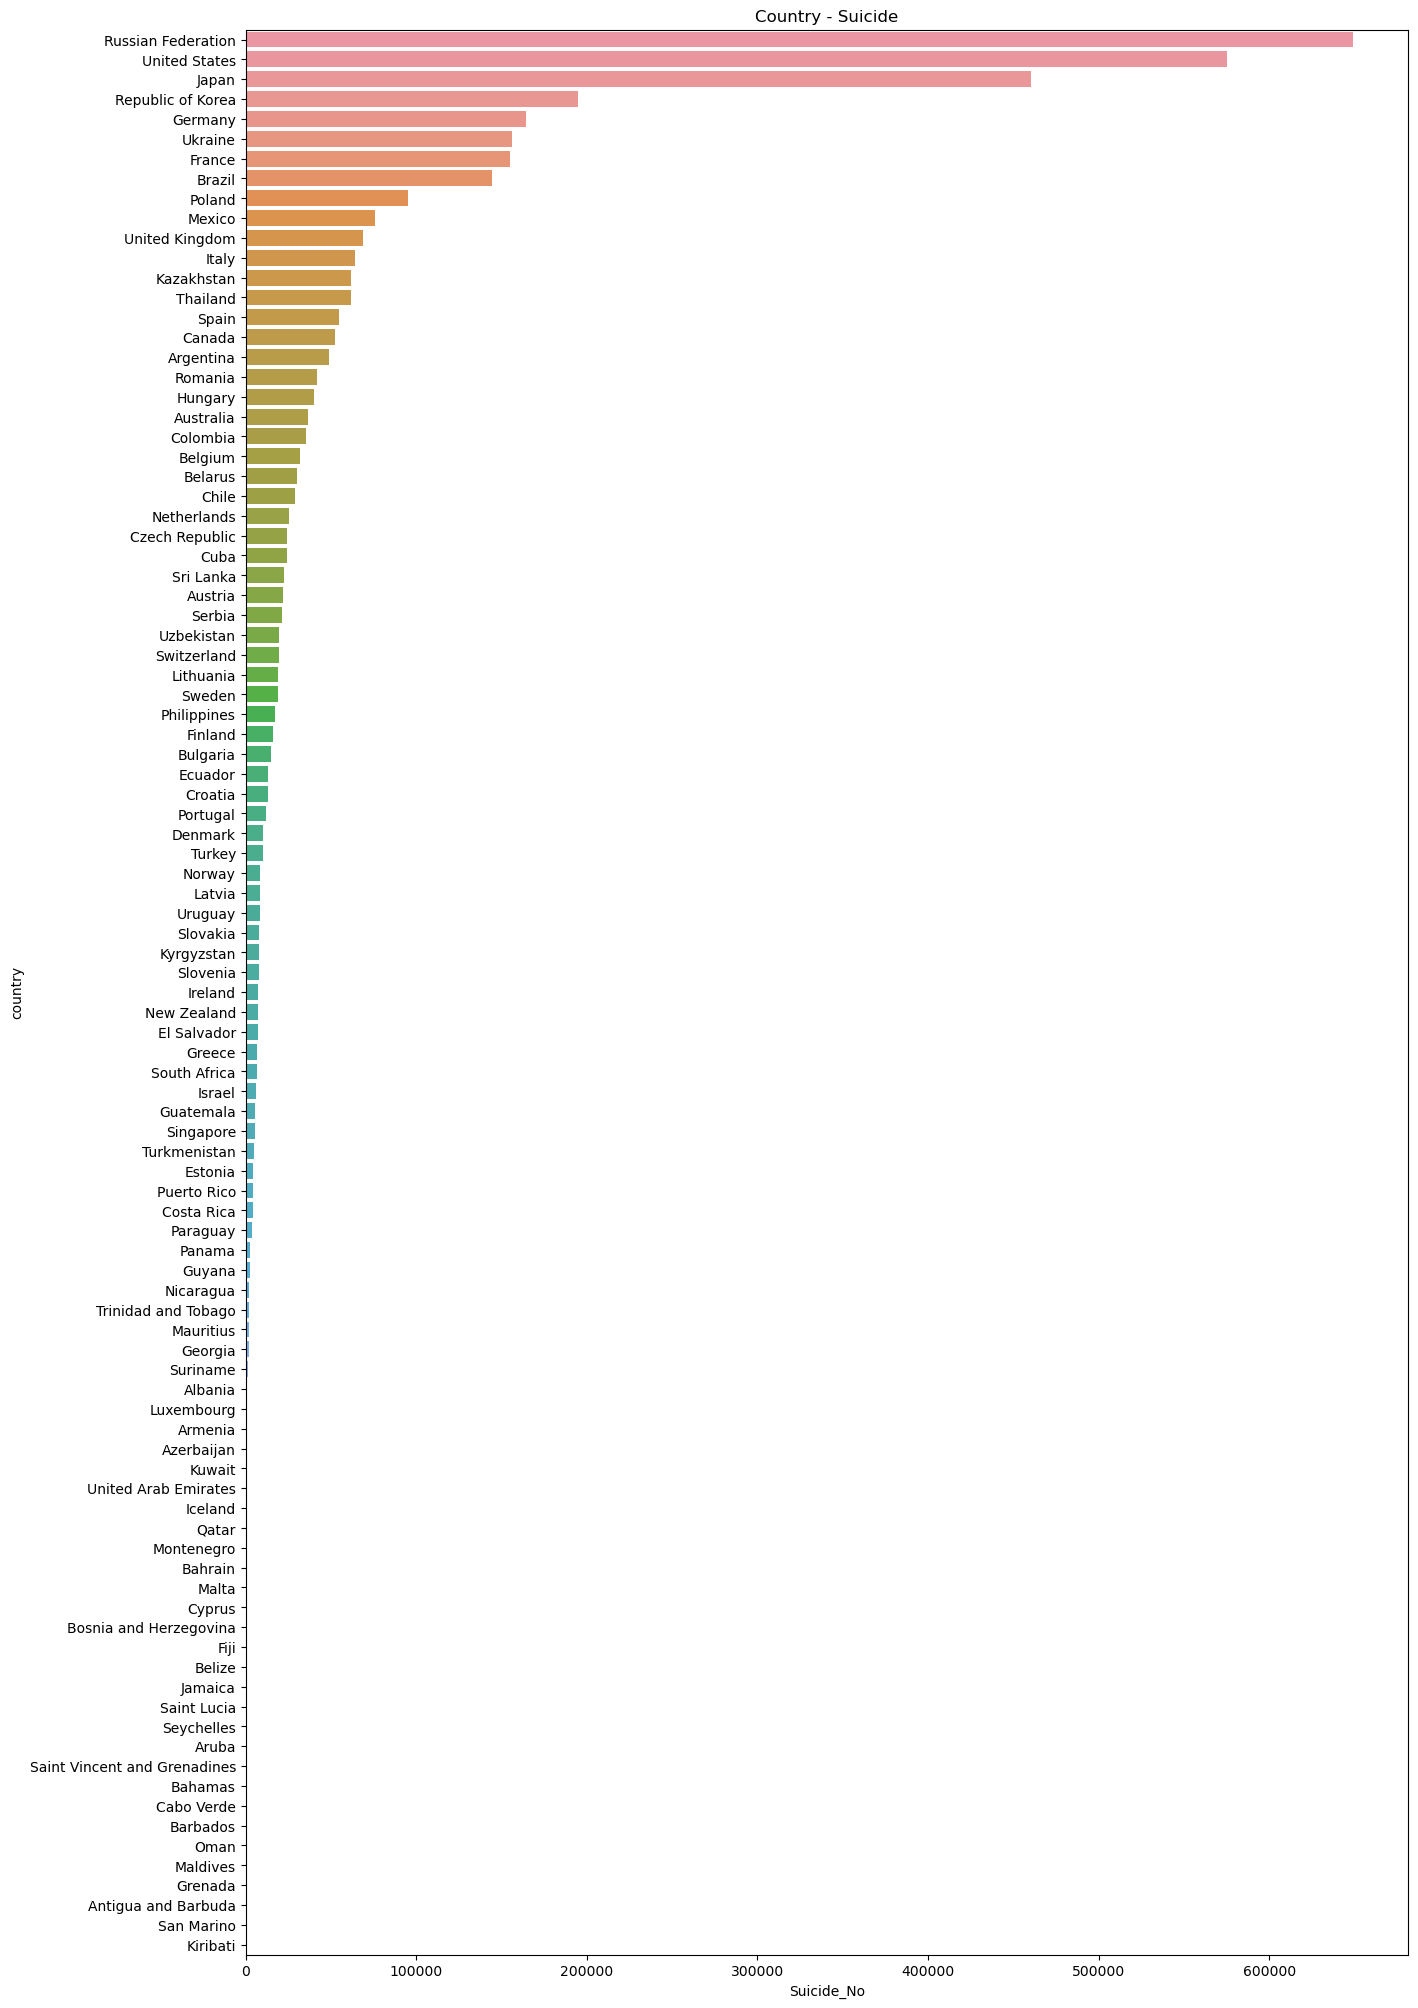

In [32]:
#Country & Suicide_rate Bar plot

plt.figure(figsize=(15,25))
sns.barplot(x = "Suicide_No", y = "country", data = df_sorted)
plt.title('Country - Suicide')
plt.show()

In [33]:
df.to_csv('suicide_modified.csv')

In [34]:
#### Exploring the Millenials and Genration X

df_millenials_genX = df[(df['generation'] == 'Millenials') | (df['generation'] == 'Generation X')]

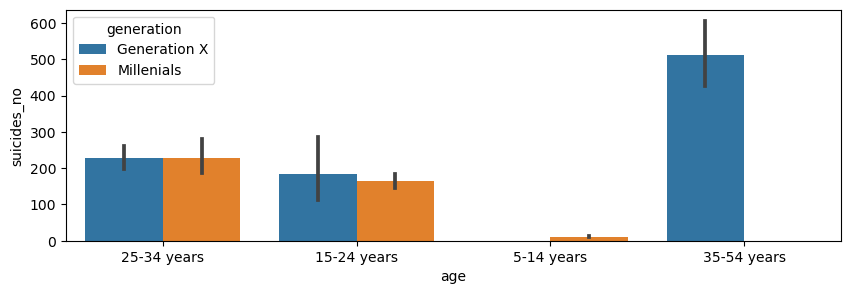

In [35]:
#Comparing suicides between Millenials and Generation X

plt.figure(figsize=(10,3))
sns.barplot(x = "age", y = "suicides_no", hue = "generation", data = df_millenials_genX)
plt.title("")
plt.show()

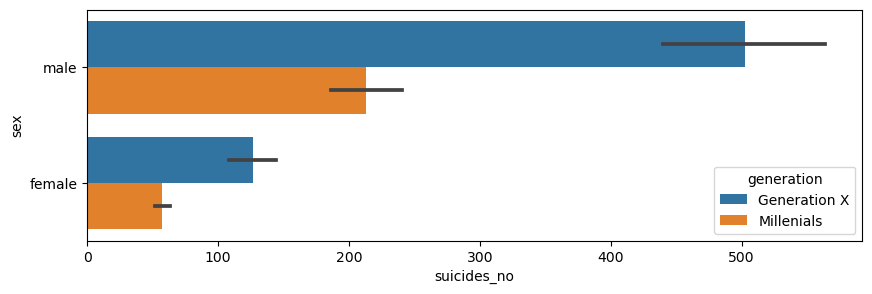

In [36]:
#Comparing suicides between Millenials and Generation X

plt.figure(figsize=(10,3))
sns.barplot(x = "suicides_no", y = "sex", hue = "generation", data = df_millenials_genX)
plt.title("")
plt.show()

In [37]:
df_adol = df[(df['age'] == '5-14 years')]

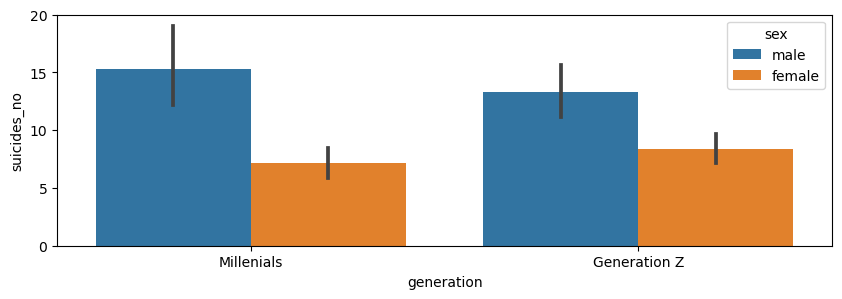

In [38]:
plt.figure(figsize=(10,3))
sns.barplot(x = "generation", y = "suicides_no", hue = "sex", data = df_adol)
plt.title("")
plt.show()

In [39]:
#### Exploring the Millenials and Genration X

df_millenials = df[(df['generation'] == 'Millenials')]

<Axes: xlabel='year', ylabel='suicides_no'>

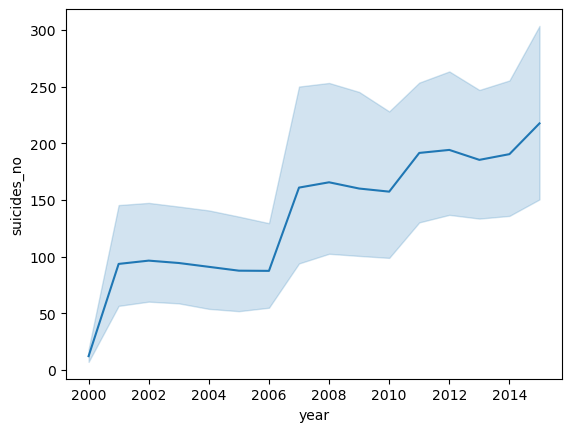

In [40]:
sns.lineplot(x='year', y='suicides_no', data=df_millenials)

<Axes: xlabel='year', ylabel='suicides_no'>

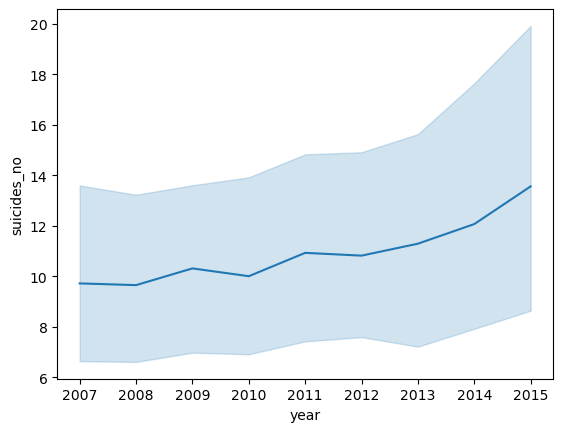

In [41]:
#### Exploring the Millenials and Genration X

df_genZ = df[(df['generation'] == 'Generation Z')]

sns.lineplot(x='year', y='suicides_no', data=df_genZ)

### Data Preprocessing

#### Dealing with null values

In [42]:
def null_val(data) :
    
    null_df = pd.DataFrame()

    i = 0

    for var in data.columns :

        if data[var].isnull().sum() > 0 :

           print(var, data[var].isnull().sum()/data.shape[0])

           null_df.loc[i,'Var_Name'] = var
           null_df.loc[i,'Percent_of_Missing_Values']= data[var].isnull().sum()/data.shape[0]

           i+=1

    null_df.sort_values(['Percent_of_Missing_Values'],ascending=False,inplace=True)

    return null_df

In [43]:
df_null = null_val(df)

df_null

HDI for year 0.5899550224887556


,Var_Name,Percent_of_Missing_Values
0,HDI for year,0.589955


In [44]:
high_null_list = df_null[df_null['Percent_of_Missing_Values']>0.5]['Var_Name'].tolist()

high_null_list

['HDI for year']

In [45]:
# Dropping columns with high null values..

df_v1 = df.drop(columns=high_null_list)

# df_v1.info()

In [46]:
numeric.remove('HDI for year')
# numeric.remove('Strength of legal rights index (0=weak to 12=strong)')

In [47]:
numeric

['year',
 'suicides_no',
 'population',
 'suicidesper100k',
 'gdp_for_year',
 'gdp_per_capita']

In [48]:
# df_v3 = df_v2[(df_v2[numeric] > 0).all(axis=1)]

In [49]:
df_extra_features = pd.read_csv('suicidedataextrafestures.csv')

df_extra_features.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicidesper100k', 'country-year', 'yearlyHDI', 'GDPpyear',
       'GDPpcapital', 'generation', 'suicide%',
       'Individuals using the Internet (% of population)',
       'Expense (% of GDP)', 'Compensation of employees',
       'Unemployment(% of total labor force)', 'Physicians (per 1,000 people)',
       'Strength of legal rights index (0=weak to 12=strong)',
       'Labor force strength', 'Life expectancy',
       'Mobile cellular subscriptions (per 100 people)',
       'Refugee population by country or territory of origin',
       'Contributing family workers, total (% of total employment) (modeled ILO estimate)',
       'Access to electricity (% of population)',
       'Lower secondary completion rate, total (% of relevant age group)'],
      dtype='object')

In [50]:
# Taking in only the required columns
df_extra = df_extra_features[['country', 'year','Compensation of employees','Unemployment(% of total labor force)','Labor force strength', 'Life expectancy']]

In [51]:
df_extra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15110 entries, 0 to 15109
Data columns (total 6 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   country                               15110 non-null  object 
 1   year                                  15110 non-null  int64  
 2   Compensation of employees             13538 non-null  float64
 3   Unemployment(% of total labor force)  15110 non-null  float64
 4   Labor force strength                  15110 non-null  int64  
 5   Life expectancy                       15110 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 708.4+ KB


In [52]:
df_null_ext = null_val(df_extra)

df_null_ext

Compensation of employees 0.10403706154864328


,Var_Name,Percent_of_Missing_Values
0,Compensation of employees,0.104037


In [53]:
high_null_list = df_null_ext[df_null_ext['Percent_of_Missing_Values']>0.5]['Var_Name'].tolist()

high_null_list

[]

In [54]:
df_extra['Compensation of employees'] = df_extra.groupby(['country'])['Compensation of employees'].apply(lambda x: x.fillna(x.mean()))

C:\Users\user\AppData\Local\Temp\ipykernel_12796\3209318320.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_extra['Compensation of employees'] = df_extra.groupby(['country'])['Compensation of employees'].apply(lambda x: x.fillna(x.mean()))


In [55]:
df_null_ext = null_val(df_extra)

df_null_ext

Compensation of employees 0.004765056254136334


,Var_Name,Percent_of_Missing_Values
0,Compensation of employees,0.004765


In [56]:
df_extra['Compensation of employees'] = df_extra['Compensation of employees'].fillna(df_extra['Compensation of employees'].mean())

In [57]:
df_extra['Compensation of employees'].isnull().sum()

0

In [58]:
df_extra[(df_extra==0).any(axis=1)]

,country,year,Compensation of employees,Unemployment(% of total labor force),Labor force strength,Life expectancy
0,Argentina,1985,0.0,0.0,0,0.0
1,Argentina,1985,0.0,0.0,0,0.0
2,Argentina,1985,0.0,0.0,0,0.0
3,Argentina,1985,0.0,0.0,0,0.0
4,Argentina,1985,0.0,0.0,0,0.0
...,...,...,...,...,...,...
15105,Uzbekistan,2014,0.0,0.0,0,0.0
15106,Uzbekistan,2014,0.0,0.0,0,0.0
15107,Uzbekistan,2014,0.0,0.0,0,0.0
15108,Uzbekistan,2014,0.0,0.0,0,0.0


In [59]:


# Identifyig the numeric variables

numeric_ext = df_extra.select_dtypes(include = ['number']).columns.values.tolist()

# numeric.remove('Id')

numeric_ext

['year',
 'Compensation of employees',
 'Unemployment(% of total labor force)',
 'Labor force strength',
 'Life expectancy']

In [60]:
num_ext =[x for x in numeric_ext if x not in ['year']]

num_ext

['Compensation of employees',
 'Unemployment(% of total labor force)',
 'Labor force strength',
 'Life expectancy']

In [61]:
# Replacing the zero values with country wise mean
for c in df_extra['country'].unique() :
                  
   for var in num_ext:
    
    
        x=df_extra.loc[df_extra['country']==c,var].mean()
#         print(x)
        df_extra.loc[df_extra['country']==c,var] =  np.where(df_extra.loc[df_extra['country']==c,var]==0,x,df_extra.loc[df_extra['country']==c,var])

In [62]:
df_extra[(df_extra[num_ext]==0).any(axis=1)]

,country,year,Compensation of employees,Unemployment(% of total labor force),Labor force strength,Life expectancy
4062,Cuba,1992,0.0,3.076167,3.787120e+06,61.205167
4063,Cuba,1992,0.0,3.076167,3.787120e+06,61.205167
4064,Cuba,1992,0.0,3.076167,3.787120e+06,61.205167
4065,Cuba,1992,0.0,3.076167,3.787120e+06,61.205167
4066,Cuba,1992,0.0,3.076167,3.787120e+06,61.205167
...,...,...,...,...,...,...
15105,Uzbekistan,2014,0.0,6.301182,7.917053e+06,49.517818
15106,Uzbekistan,2014,0.0,6.301182,7.917053e+06,49.517818
15107,Uzbekistan,2014,0.0,6.301182,7.917053e+06,49.517818
15108,Uzbekistan,2014,0.0,6.301182,7.917053e+06,49.517818


In [63]:
#Replacing the remaining zeroes with the column mean

for var in num_ext:
    
    x=df_extra[var].mean()
#         print(x)
    df_extra[var] =  np.where(df_extra[var]==0,x,df_extra[var])

In [64]:
df_extra[(df_extra[num_ext]==0).any(axis=1)]

,country,year,Compensation of employees,Unemployment(% of total labor force),Labor force strength,Life expectancy


In [65]:
df_v1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16008 entries, 132 to 27819
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country          16008 non-null  object 
 1   year             16008 non-null  int64  
 2   sex              16008 non-null  object 
 3   age              16008 non-null  object 
 4   suicides_no      16008 non-null  int64  
 5   population       16008 non-null  int64  
 6   suicidesper100k  16008 non-null  float64
 7   gdp_for_year     16008 non-null  float64
 8   gdp_per_capita   16008 non-null  int64  
 9   generation       16008 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 1.3+ MB


In [66]:
#Joing df_extra to the main data frame

suicide_master = df_v1.merge(df_extra,right_on=['country','year'],left_on=['country','year'],how='inner').drop_duplicates()

suicide_master

,country,year,sex,age,suicides_no,population,suicidesper100k,gdp_for_year,gdp_per_capita,generation,Compensation of employees,Unemployment(% of total labor force),Labor force strength,Life expectancy
0,Argentina,2000,male,75+ years,232,525161,44.18,2.842038e+11,8462,G.I. Generation,14.694699,15.000000,1.644684e+07,73.576000
12,Argentina,2000,male,55-74 years,602,2333377,25.80,2.842038e+11,8462,Silent,14.694699,15.000000,1.644684e+07,73.576000
24,Argentina,2000,male,35-54 years,578,4096814,14.11,2.842038e+11,8462,Boomers,14.694699,15.000000,1.644684e+07,73.576000
36,Argentina,2000,male,15-24 years,463,3306109,14.00,2.842038e+11,8462,Generation X,14.694699,15.000000,1.644684e+07,73.576000
48,Argentina,2000,male,25-34 years,331,2602314,12.72,2.842038e+11,8462,Generation X,14.694699,15.000000,1.644684e+07,73.576000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99876,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,6.306708e+10,2309,Generation X,12.453690,6.301182,7.917053e+06,49.517818
99888,Uzbekistan,2014,female,75+ years,9,348465,2.58,6.306708e+10,2309,Silent,12.453690,6.301182,7.917053e+06,49.517818
99900,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,6.306708e+10,2309,Generation Z,12.453690,6.301182,7.917053e+06,49.517818
99912,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,6.306708e+10,2309,Generation Z,12.453690,6.301182,7.917053e+06,49.517818


In [67]:
num_master = set(numeric + num_ext)

num_master

{'Compensation of employees',
 'Labor force strength',
 'Life expectancy',
 'Unemployment(% of total labor force)',
 'gdp_for_year',
 'gdp_per_capita',
 'population',
 'suicides_no',
 'suicidesper100k',
 'year'}

#### Applying K-Means algorithm

In [68]:
cols = list(num_master)

In [69]:
# cols.remove('year')

In [70]:
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import MinMaxScaler

std_scaler = StandardScaler()

minmax_scaler = MinMaxScaler()

# X = std_scaler.fit_transform(df_v3[numeric])

X = minmax_scaler.fit_transform(suicide_master[num_master])

X = pd.DataFrame(X, columns= cols)

C:\Users\user\AppData\Local\Temp\ipykernel_12796\2547779469.py:11: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X = minmax_scaler.fit_transform(suicide_master[num_master])


In [71]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8328 entries, 0 to 8327
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   suicides_no                           8328 non-null   float64
 1   year                                  8328 non-null   float64
 2   gdp_for_year                          8328 non-null   float64
 3   Compensation of employees             8328 non-null   float64
 4   population                            8328 non-null   float64
 5   Unemployment(% of total labor force)  8328 non-null   float64
 6   Labor force strength                  8328 non-null   float64
 7   Life expectancy                       8328 non-null   float64
 8   suicidesper100k                       8328 non-null   float64
 9   gdp_per_capita                        8328 non-null   float64
dtypes: float64(10)
memory usage: 650.8 KB


In [72]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

In [73]:
def cluster_algo(d) :
    cs = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
        kmeans.fit(d)
        cs.append(kmeans.inertia_)
    plt.plot(range(1, 11), cs)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('CS')
    plt.show()
    
    

In [74]:
 df_clust = X.copy()

In [75]:
# df_clust_v1 = df_clust[['GDPpyear','GDPpcapital','suicidesper100k']]


# df_clust_v1 = df_clust[['GDPpyear','GDPpcapital','Contributing family workers, total (% of total employment) (modeled ILO estimate)','Unemployment, total (% of total labor force) (modeled ILO estimate)']]

# df_clust_v1 = df_clust[['Contributing family workers, total (% of total employment) (modeled ILO estimate)','Unemployment, total (% of total labor force) (modeled ILO estimate)','suicidesper100k']]

In [76]:
df_clust_v1 = df_clust[['suicidesper100k']]

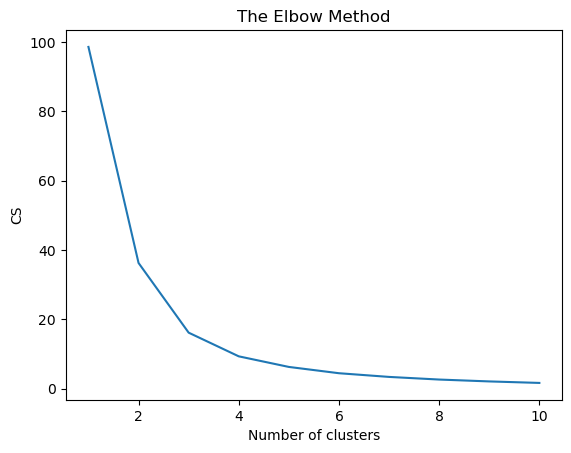

In [77]:
cluster_algo(df_clust_v1)

In [78]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
kmeans.fit(df_clust_v1)


KMeans(n_clusters=3, n_init=10, random_state=0)

In [79]:
print(silhouette_score(df_clust_v1,kmeans.labels_))
cluster_df=pd.DataFrame({'cluster':kmeans.labels_,'sil_score':silhouette_samples(df_clust_v1,kmeans.labels_)})
cluster_df.groupby(['cluster'])['sil_score'].mean()

0.6731263374780011


cluster
0    0.525881
1    0.733328
2    0.511145
Name: sil_score, dtype: float64

In [80]:
suicide_master['suicide_cluster'] = kmeans.labels_

In [81]:
suicide_master.to_csv('suicide_master.csv',index=False)

In [82]:
suicide_master.groupby(['suicide_cluster']).mean()

C:\Users\user\AppData\Local\Temp\ipykernel_12796\1225675938.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  suicide_master.groupby(['suicide_cluster']).mean()


,year,suicides_no,population,suicidesper100k,gdp_for_year,gdp_per_capita,Compensation of employees,Unemployment(% of total labor force),Labor force strength,Life expectancy
suicide_cluster,,,,,,,,,,
0,2006.296296,2142.268519,3.305851e+06,68.784537,7.351948e+11,20265.021605,13.539987,7.561481,2.380159e+07,72.846026
1,2007.576860,172.971405,3.168816e+06,4.879170,8.960601e+11,24708.145950,14.900767,8.417324,1.833667e+07,72.898632
2,2007.105425,809.404811,3.103296e+06,25.591827,1.286832e+12,31925.096213,13.240831,7.212974,1.911280e+07,74.914790


In [83]:
suicide_master.groupby(['suicide_cluster']).median()

C:\Users\user\AppData\Local\Temp\ipykernel_12796\2164741240.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  suicide_master.groupby(['suicide_cluster']).median()


,year,suicides_no,population,suicidesper100k,gdp_for_year,gdp_per_capita,Compensation of employees,Unemployment(% of total labor force),Labor force strength,Life expectancy
suicide_cluster,,,,,,,,,,
0,2006.0,512.5,800704.5,66.055,2.067782e+11,13525.0,12.975347,7.184000,5.129176e+06,74.260976
1,2008.0,41.0,1135386.5,3.710,2.699801e+11,16169.0,12.669405,7.375000,7.095832e+06,75.784000
2,2007.0,256.0,1036579.0,23.800,2.750200e+11,31033.5,11.625899,6.715759,5.130305e+06,78.330000


In [84]:
#Changing the type of the year variable from numeric to string

suicide_master['year'] = suicide_master['year'].astype(int)

In [85]:
suicide_master['year'] = suicide_master['year'].astype(str)

In [86]:
# Drop the column suicide_no as this column is used to predict suicide rates

sm_1 = suicide_master.drop(columns=['suicides_no'])

In [87]:
#Drop the suicide cluster column to see how this affects the model

sm_2 = sm_1.drop(columns=['suicide_cluster'])

In [88]:
# Re - identifying the numeric variables

# Identifyig the numeric variables

numeric_cols = suicide_master.select_dtypes(include = ['number']).columns.values.tolist()

# numeric.remove('Id')

numeric_cols

['suicides_no',
 'population',
 'suicidesper100k',
 'gdp_for_year',
 'gdp_per_capita',
 'Compensation of employees',
 'Unemployment(% of total labor force)',
 'Labor force strength',
 'Life expectancy',
 'suicide_cluster']

In [89]:
numeric_cols.remove('suicides_no')

numeric_cols.remove('suicidesper100k')

numeric_cols

['population',
 'gdp_for_year',
 'gdp_per_capita',
 'Compensation of employees',
 'Unemployment(% of total labor force)',
 'Labor force strength',
 'Life expectancy',
 'suicide_cluster']

In [90]:
numeric_cols_2 = numeric_cols

numeric_cols_2.remove('suicide_cluster')

In [91]:
numeric_cols_2

['population',
 'gdp_for_year',
 'gdp_per_capita',
 'Compensation of employees',
 'Unemployment(% of total labor force)',
 'Labor force strength',
 'Life expectancy']

In [92]:
# Re-identifying the  categoricl variables

cat_cols = suicide_master.select_dtypes(include = ['object']).columns.values.tolist()

cat_cols
    

['country', 'year', 'sex', 'age', 'generation']

In [93]:
from sklearn.preprocessing import RobustScaler

rb_scaler = RobustScaler()

sm_1[numeric_cols] = rb_scaler.fit_transform(sm_1[numeric_cols])

sm_2[numeric_cols] = rb_scaler.fit_transform(sm_2[numeric_cols_2])

In [94]:
from sklearn.preprocessing import LabelEncoder

l_encoder = LabelEncoder()

for c in cat_cols :
    

 sm_1[c] = l_encoder.fit_transform(sm_1[c])

 sm_2[c] = l_encoder.fit_transform(sm_2[c])

### Modeling

In [95]:
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

In [96]:
# #Creating the Pipelines

# numeric_transformer = Pipeline(steps=[
#        ('scaler', StandardScaler())])

# categorical_transformer = Pipeline(steps=[
#     ('OrdEncoder', OrdinalEncoder())])

# preprocessor = ColumnTransformer(
# transformers=[
#     ('num', numeric_transformer, numeric_cols),
#     ('cat', categorical_transformer, cat_cols)])

In [97]:
# clf_lr = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', LinearRegression())])    
    
# clf_enet = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', ElasticNet())])    

# clf_knn  = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', KNeighborsRegressor())])  

# clf_svr =  Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', SVR())]) 

# clf_dt = DecisionTreeRegressor()

# clf_rf = RandomForestRegressor()

# clf_xgb = XGBRegressor()

In [98]:
clf_lr = LinearRegression() 
    
clf_enet = ElasticNet()

clf_knn  = KNeighborsRegressor()

clf_svr =  SVR()

clf_dt = DecisionTreeRegressor()

clf_rf = RandomForestRegressor()

clf_xgb = XGBRegressor()

In [99]:
#ml_model_pipeline = [clf_lr, clf_enet, clf_knn,clf_svr, clf_dt]

ml_model_pipeline = [clf_lr, clf_enet, clf_knn,clf_svr, clf_dt, clf_rf,clf_xgb]

In [100]:
X = sm_1.drop(columns=['suicidesper100k'])

Y = sm_1['suicidesper100k']

In [101]:
score_dict = dict()
for model in ml_model_pipeline :
    
    score = cross_val_score(model, X, Y, cv = 5).mean()
    score_dict[model] = score
    
    

In [102]:
score_dict

{LinearRegression(): 0.16721064649647,
 ElasticNet(): 0.11073520010753957,
 KNeighborsRegressor(): 0.020040513472160272,
 SVR(): 0.028219158657935162,
 DecisionTreeRegressor(): 0.7221315443680216,
 RandomForestRegressor(): 0.8205518623596163,
 XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [103]:
cols = ['Model_Score']

cross_val_score_frame = pd.DataFrame.from_dict(score_dict,orient='index',columns= cols).reset_index()

cross_val_score_frame

,index,Model_Score
0,LinearRegression(),0.167211
1,ElasticNet(),0.110735
2,KNeighborsRegressor(),0.020041
3,SVR(),0.028219
4,DecisionTreeRegressor(),0.722132
5,RandomForestRegressor(),0.820552
6,"XGBRegressor(base_score=None, booster=None, ca...",0.783042


#### Cross val score without the suicide cluster



In [104]:
X = sm_2.drop(columns=['suicidesper100k'])

Y = sm_2['suicidesper100k']

In [105]:
score_dict = dict()
for model in ml_model_pipeline :
    
    score = cross_val_score(model, sm_2.drop(columns=['suicidesper100k']), sm_2['suicidesper100k'],scoring='r2', cv = 5).mean()
    score_dict[model] = score
    
    

score_dict

{LinearRegression(): 0.1678380965499266,
 ElasticNet(): 0.11079958232722045,
 KNeighborsRegressor(): 0.08638192584705713,
 SVR(): 0.012235088479376178,
 DecisionTreeRegressor(): -0.05941863813230306,
 RandomForestRegressor(): 0.33780076675138376,
 XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, 

In [106]:
cols = ['Model_Score']

cross_val_score_frame = pd.DataFrame.from_dict(score_dict,orient='index',columns= cols).reset_index()

cross_val_score_frame

,index,Model_Score
0,LinearRegression(),0.167838
1,ElasticNet(),0.110800
2,KNeighborsRegressor(),0.086382
3,SVR(),0.012235
4,DecisionTreeRegressor(),-0.059419
5,RandomForestRegressor(),0.337801
6,"XGBRegressor(base_score=None, booster=None, ca...",0.289762


#### Train test split

In [107]:
X_train, X_test, y_train, y_test = train_test_split(sm_2.drop(columns=['suicidesper100k']), sm_2['suicidesper100k'], test_size = 0.3, random_state = 10)
X_train.shape, X_test.shape

((5829, 12), (2499, 12))

#### Applying Grid Search,and RandomSearch

In [108]:
# Creating holders to store the model performance results
ML_Model = []
acc_train = []
acc_test = []
rmse_train_list = []
rmse_test_list = []

#function to call for storing the results
def Results(model, a,b,c,d):
    ML_Model.append(model)
    acc_train.append(round(a, 3))
    acc_test.append(round(b, 3))
    rmse_train_list.append(round(c, 3))
    rmse_test_list.append(round(d, 3))

#### Decision Tree Regressor

In [109]:
# Define the grid of hyperparameters 'params_dt'

dt = DecisionTreeRegressor()

params_dt = {
'min_samples_split': [5, 10,12, 15,18, 20,22, 25, 30],
'max_depth': [7, 8,9, 10, 11, 12, 13],
'min_samples_leaf': [0.02, 0.025,0.03,0.04,0.05,0.06, 0.1],
'max_features': [ 0.4,0.6,0.7, 0.8, 0.85, 0.9],
'max_leaf_nodes': [20, 22, 25,35,40,45, 50,52 ]
}
# Instantiate a 10-fold CV grid search object 'grid_dt'
grid_dt = GridSearchCV(estimator=dt,
param_grid=params_dt,
scoring= 'r2',
cv=5,
n_jobs=-1)

grid_dt.fit(X_train, y_train)

# Extract best model from 'grid_dt'
best_modelDT = grid_dt.best_params_

print(best_modelDT)

{'max_depth': 8, 'max_features': 0.85, 'max_leaf_nodes': 45, 'min_samples_leaf': 0.02, 'min_samples_split': 18}


In [110]:
best_hp_DT = {
    'max_depth': int(best_modelDT['max_depth']), 
    'max_features': best_modelDT['max_features'],
    'max_leaf_nodes':best_modelDT['max_leaf_nodes'],
    'min_samples_leaf': best_modelDT['min_samples_leaf'],
    'min_samples_split': best_modelDT['min_samples_split']
        }

DT_final = DecisionTreeRegressor(**best_hp_DT)

DT_final.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, max_features=0.85, max_leaf_nodes=45,
                      min_samples_leaf=0.02, min_samples_split=18)

In [111]:
y_predDT_train = DT_final.predict(X_train)
y_predDT = DT_final.predict(X_test)

y_predDT = np.round(y_predDT)

r_sq_train = DT_final.score(X_train,y_train)
r_sq_test = DT_final.score(X_test,y_test)

print(r_sq_train)
print(r_sq_test)

#computing root mean squared error (RMSE)

rmse_train = np.sqrt(mean_squared_error(y_train, y_predDT_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_predDT))

print(rmse_train)
print(rmse_test)


predDT = pd.DataFrame(y_predDT, columns = ['random_forest'])

Results('DecisionTree',r_sq_train,r_sq_test,rmse_train,rmse_test)

0.5414539509360794
0.5356801983552726
10.55153428577983
10.846399844918052


#### RandomForest

In [112]:
# random forests
rf_model = RandomForestRegressor(
    n_estimators=100, max_depth=3, random_state=0, n_jobs=4)

# hyperparameter space
rf_param_grid = dict(
    n_estimators=[5,8,  10, 20,40, 45, 50,55,60, 70 , 80, 100,120],
    max_depth=[2, 5, 6, 7, 8, 9, 10, 11, 12, 13],
    min_samples_split=[2,3, 4,5, 6, 7, 8]
)

# search
reg = GridSearchCV(rf_model, rf_param_grid,
                   scoring='r2', cv=5)

RF_Model1 = reg.fit(X_train, y_train)

# best hyperparameters
best_modelRF =RF_Model1.best_params_

In [113]:
best_hp_RF = {
        'max_depth': int(best_modelRF['max_depth']), 
        'min_samples_split': int(best_modelRF['min_samples_split']), 
        'n_estimators': int(best_modelRF['n_estimators'])
        }

print(best_hp_RF)

{'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 100}


In [114]:
RF_final = RandomForestRegressor(**best_hp_RF)

RF_final.fit(X_train, y_train)

RandomForestRegressor(max_depth=13, min_samples_split=3)

In [115]:
y_predRF_train = RF_final.predict(X_train)
y_predRF = RF_final.predict(X_test)


r_sq_train = RF_final.score(X_train,y_train)
r_sq_test = RF_final.score(X_test,y_test)

print(r_sq_train)
print(r_sq_test)

#computing root mean squared error (RMSE)

rmse_train = np.sqrt(mean_squared_error(y_train, y_predRF_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_predRF))

print(rmse_train)
print(rmse_test)


predRF = pd.DataFrame(y_predRF, columns = ['random_forest'])

Results('RandomForest',r_sq_train,r_sq_test,rmse_train,rmse_test)

0.9794249446688481
0.9222710699455593
2.2350880801950312
4.434975300142286


#### XGBoost

In [116]:
param_dist = {
        'n_estimators':range(50,150,5),
        'max_depth':range(2,15,1),
        'learning_rate':np.linspace(0.01,1,25),
        'subsample':np.linspace(0.1,0.9,25),
        'colsample_bytree':np.linspace(0.3,0.8,20),
        'min_child_weight':range(1,9,1),
        'gamma': [0, 0.2,0.25, 0.3,0.35, 0.5, 1.0],
        'reg_lambda': [ 1,2, 5,8, 9 ,10,  15,  50, 100, 110, 120]
        }


xgbr = XGBRegressor()
XGB_Model = RandomizedSearchCV(xgbr, 
                   param_dist,
                   scoring='r2', 
                   verbose=1,
                    cv = 5,
                    n_iter=125,
                    n_jobs = -1)
XGB_Model.fit(X_train, y_train)
print("Best parameters:", XGB_Model.best_params_)

best_modelXGB =XGB_Model.best_params_

Fitting 5 folds for each of 125 candidates, totalling 625 fits
Best parameters: {'subsample': 0.8666666666666666, 'reg_lambda': 100, 'n_estimators': 135, 'min_child_weight': 2, 'max_depth': 12, 'learning_rate': 0.2575, 'gamma': 0.5, 'colsample_bytree': 0.7210526315789474}


In [117]:
print(best_modelXGB)

best_hp_XGB = {
        'subsample' : best_modelXGB['subsample'],
        'reg_lambda': best_modelXGB['reg_lambda'],
        'n_estimators': int(best_modelXGB['n_estimators']),
        'min_child_weight': best_modelXGB['min_child_weight'],
        'max_depth': int(best_modelXGB['max_depth']), 
        'learning_rate' : best_modelXGB['learning_rate'],
        'gamma': best_modelXGB['gamma'],
        'colsample_bytree': best_modelXGB['colsample_bytree']
        
        }

XGB_final = XGBRegressor(**best_hp_XGB)

{'subsample': 0.8666666666666666, 'reg_lambda': 100, 'n_estimators': 135, 'min_child_weight': 2, 'max_depth': 12, 'learning_rate': 0.2575, 'gamma': 0.5, 'colsample_bytree': 0.7210526315789474}


In [118]:
XGB_final.fit(X_train, y_train)


y_predXGBoost_train = XGB_final.predict(X_train)
y_predXGBoost = XGB_final.predict(X_test)

r_sq_train = XGB_final.score(X_train,y_train)
r_sq_test = XGB_final.score(X_test,y_test)


print(r_sq_train)
print(r_sq_test)

#computing root mean squared error (RMSE)

rmse_train = np.sqrt(mean_squared_error(y_train, y_predXGBoost_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_predXGBoost))

print(rmse_train)
print(rmse_test)


predXGBoost = pd.DataFrame(y_predXGBoost, columns = ['xg_boost'])


Results('XGBoost',r_sq_train,r_sq_test,rmse_train,rmse_test)

0.9879710508496207
0.9349546381152185
1.7089839382326248
4.057028212138408


#### Linear Regressor

In [119]:
lr = LinearRegression()
# fit the model 
lr.fit(X_train, y_train)

LinearRegression()

In [120]:
#predicting the target value from the model for the samples

y_pred_lr_train = lr.predict(X_train)

y_pred_lr = lr.predict(X_test)

In [121]:
y_pred_lr = np.round(y_pred_lr)

r_sq_train = lr.score(X_train,y_train)
r_sq_test = lr.score(X_test,y_test)

print(r_sq_train)
print(r_sq_test)

#computing root mean squared error (RMSE)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_lr_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print(rmse_train)
print(rmse_test ) 

predLR = pd.DataFrame(y_pred_lr, columns = ['Linear Regression'])



Results('LinearRegression',r_sq_train,r_sq_test,rmse_train,rmse_test)

0.2879092401568003
0.2770320376880959
13.148972337896183
13.532444814779998


#### ElasticNet Regressor

In [122]:
# from sklearn.model_selection import GridSearchCV # If not already imported

from sklearn.linear_model import ElasticNet
alpha_values = {'alpha':[0.00005,0.0005,0.001, 0.01,0.02, 0.05, 0.06,0.7, 0.08,0.9, 1, 2, 3, 5, 8, 10, 20, 50, 100],
 'l1_ratio':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.85, 0.9,1]}

elastic= GridSearchCV(ElasticNet(), alpha_values, scoring='r2', cv=10 )

model_elastic = elastic.fit(X_train,y_train)

In [123]:
best_modelElastic = model_elastic.best_params_

print(best_modelElastic)

best_hp_Elastic = {
        'alpha' : best_modelElastic['alpha'],
        'l1_ratio': best_modelElastic['l1_ratio']      
        }

Elastic_final = ElasticNet(**best_hp_Elastic)

{'alpha': 0.02, 'l1_ratio': 1}


In [124]:
Elastic_final.fit(X_train, y_train)


y_pred_Elastic_train = Elastic_final.predict(X_train)
y_pred_Elastic = Elastic_final.predict(X_test)

In [125]:
y_pred_Elastic = np.round(y_pred_Elastic)



r_sq_train = Elastic_final.score(X_train,y_train)
r_sq_test = Elastic_final.score(X_test,y_test)

print(r_sq_train)
print(r_sq_test)

#computing root mean squared error (RMSE)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_Elastic_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_Elastic))

print(rmse_train)
print(rmse_test ) 

predENet = pd.DataFrame(y_pred_Elastic, columns = ['elastic_net'])



Results('ElasticNet',r_sq_train,r_sq_test,rmse_train,rmse_test)

0.2878822043519579
0.2770004765058812
13.149221947704289
13.535050604927607


#### SVM Regressor

In [126]:
# #Hyperparamter tuning using Gridsearch
# svm = SVR()
# # param_grid = {'C':[0.01,0.05,0.1,1,10, 100, 1000],'kernel':['linear','rbf'], 'gamma':['scale','auto'] }
# param_grid = {'C': [0.1, 1, 10, 100, 1000],
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf','linear']}
# svm_grid = GridSearchCV(svm,param_grid,cv=10,verbose=1,n_jobs=-1)

# svm_model = svm_grid.fit(X_train,y_train)

In [127]:
# best_svm_params = svm_model.best_params_

# print(best_svm_params)

# best_hp_svm = {
#         'C' : best_svm_params['C'],
#         'gamma': best_svm_params['gamma']      
#          'kernel':best_svm_params['kernel'] 
#         }

# svm_final = SVR(**best_hp_svm)

In [128]:
# svm_final.fit(X_train, y_train)


# y_predSVM_train = svm_final.predict(X_train)
# y_predSVM = svm_final.predict(X_test)

In [129]:
# y_predSVM = np.round(y_predSVM)

# r_sq_train = svm_final.score(X_train,y_train)
# r_sq_test = svm_final.score(X_test,y_test)

# #computing root mean squared error (RMSE)

# rmse_train = np.sqrt(mean_squared_error(y_train, y_predSVM_train))
# rmse_test = np.sqrt(mean_squared_error(y_test, y_predSVM))

# predSVM = pd.DataFrame(y_predSVM, columns = ['SVM'])

# Results('SupportVectorRegressor',r_sq_train,r_sq_test,rmse_train,rmse_test)

#### KNNRegressor

In [130]:
knn = KNeighborsRegressor()

param_grid = {'n_neighbors':list(range(1, 31)), 'weights': ['uniform', 'distance']}

# instantiate the grid
knn_grid = GridSearchCV(knn, param_grid , cv=10)

knn_model = knn_grid.fit(X_train,y_train)

In [131]:
best_knn_params = knn_model.best_params_

print(best_knn_params)

best_hp_knn = {
        'n_neighbors' : best_knn_params['n_neighbors'],
        'weights': best_knn_params['weights']      
        }

knn_final = KNeighborsRegressor(**best_hp_knn)

{'n_neighbors': 5, 'weights': 'distance'}


In [132]:
knn_final.fit(X_train, y_train)

y_predkNN_train = knn_final.predict(X_train)

y_predkNN = knn_final.predict(X_test)

In [133]:
y_predkNN = np.round(y_predkNN)

r_sq_train = knn_final.score(X_train,y_train)
r_sq_test = knn_final.score(X_test,y_test)

print(r_sq_train)
print(r_sq_test)

#computing root mean squared error (RMSE)

rmse_train = np.sqrt(mean_squared_error(y_train, y_predkNN_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_predkNN))

print(rmse_train)
print(rmse_test) 

predKNN = pd.DataFrame(y_predkNN, columns = ['KNN'])

Results('KNearestNeighborRegressor',r_sq_train,r_sq_test,rmse_train,rmse_test)

1.0
0.5108434608696659
0.0
11.128919128845826


In [134]:
results_df = pd.DataFrame( { 'model_name' : ML_Model , 'Training_R_Squared' : acc_train ,'Testing_R_Squared' : acc_test,'RMSE_Train': rmse_train_list,'RMSE_Test' : rmse_test_list})
results_df

,model_name,Training_R_Squared,Testing_R_Squared,RMSE_Train,RMSE_Test
0,DecisionTree,0.541,0.536,10.552,10.846
1,RandomForest,0.979,0.922,2.235,4.435
2,XGBoost,0.988,0.935,1.709,4.057
3,LinearRegression,0.288,0.277,13.149,13.532
4,ElasticNet,0.288,0.277,13.149,13.535
5,KNearestNeighborRegressor,1.000,0.511,0.000,11.129


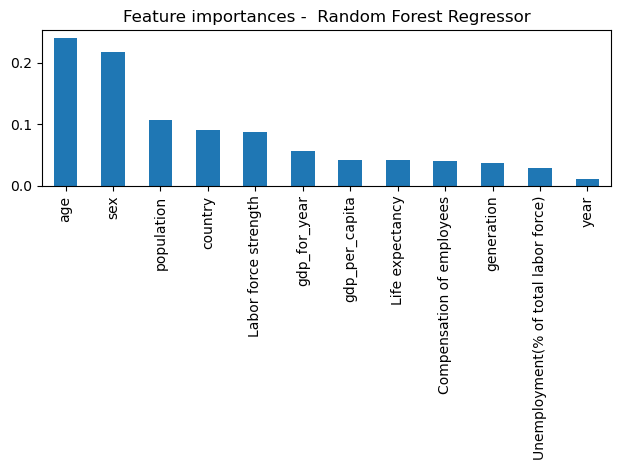

In [135]:
importances = RF_final.feature_importances_

feature_importance = pd.Series(importances,index=X_train.columns)

feature_importance.sort_values(inplace=True,ascending=False)


feature_importance

feature_importance_top15 = feature_importance[:15]
fig, ax = plt.subplots()
feature_importance_top15.plot.bar(ax=ax)
ax.set_title("Feature importances -  Random Forest Regressor")
# ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
fig.tight_layout()
plt.savefig('Feature importances - Random Forest Regressor DataSet02.png',dpi=110,bbox_inches='tight')

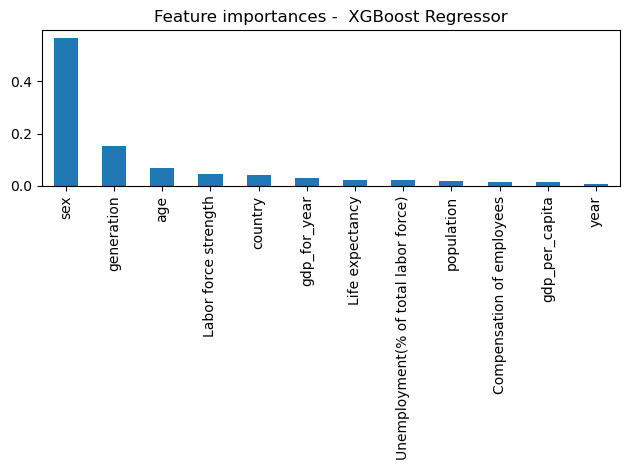

In [136]:
importances = XGB_final.feature_importances_

feature_importance = pd.Series(importances,index=X_train.columns)

feature_importance.sort_values(inplace=True,ascending=False)


feature_importance

feature_importance_top15 = feature_importance[:15]
fig, ax = plt.subplots()
feature_importance_top15.plot.bar(ax=ax)
ax.set_title("Feature importances -  XGBoost Regressor")
# ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
fig.tight_layout()
plt.savefig('Feature importances -  XGBoost Forest Regressor DataSet02.png',dpi=110,bbox_inches='tight')

#### Stacking Regressor

In [137]:
from sklearn.ensemble import StackingRegressor

In [138]:
pred_df = pd.concat([pd.Series(y_predRF),pd.Series(y_predXGBoost)],axis=1)

pred_df

,0,1
0,0.595849,0.608501
1,4.237366,4.041769
2,7.554722,8.386719
3,2.803652,2.478237
4,19.615747,17.377920
...,...,...
2494,7.322738,7.460739
2495,20.326401,22.826012
2496,3.519227,3.132495
2497,9.061347,9.788297


In [139]:
estimators = [('rf', RandomForestRegressor(max_depth= 13, min_samples_split = 2, n_estimators = 100)),
             ('xgbr',XGBRegressor( subsample= 0.7999999999999999, reg_lambda = 1, n_estimators= 105, min_child_weight = 5, max_depth = 10, learning_rate = 0.0925, gamma = 0.2, colsample_bytree = 0.4842105263157894))]

stregr = StackingRegressor(
  estimators=estimators,
     final_estimator=RandomForestRegressor(n_estimators=10,
                                           random_state=42))

stregr.fit(X_train,y_train)

stregr.score(X_test,y_test)

# stregr =   StackingRegressor(estimators=[('rf',RandomForestRegressor('max_depth': 13, 'min_samples_split': 2, 'n_estimators': 100)),('xgbr',xgb.XGBRegressor('subsample': 0.7999999999999999, 'reg_lambda': 1, 'n_estimators': 105, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.0925, 'gamma': 0.2, 'colsample_bytree': 0.4842105263157894))],final_estimator=RandomForestRegressor(n_estimators=10,random_state=42))

0.9470056404737474

In [140]:
!pip install mlxtend

Defaulting to user installation because normal site-packages is not writeable


In [141]:
stregr.fit(X_train,y_train)

#Getting the predictions of the Stacking Regressor

stacking_pred = stregr.predict(X_test)

test_score = stregr.score(X_test,y_test)

print(test_score)

0.9398398092198545
